# Breaching privacy

This notebook does the same job as the cmd-line tool `breach.py`, but also directly visualizes the user data and reconstruction

In [1]:
import torch
import hydra
from omegaconf import OmegaConf, open_dict
%load_ext autoreload
%autoreload 2

import breaching
import logging
logging.basicConfig(level=logging.INFO, handlers=[logging.StreamHandler(sys.stdout)], format='%(message)s')
logger = logging.getLogger()

### Initialize cfg object and system setup:

This will print out all configuration options. 
There are a lot of possible configurations, but there is usually no need to worry about most of these. Below, a few options are printed.

In [2]:
with hydra.initialize(config_path="config"):
    cfg = hydra.compose(config_name='cfg', overrides=[])
    print(f'Investigating use case {cfg.case.name} with server type {cfg.case.server.name}.')
    print('Attack settings are:')
    print(OmegaConf.to_yaml(cfg.attack))
          
device = torch.device(f'cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.backends.cudnn.benchmark = cfg.case.impl.benchmark
setup = dict(device=device, dtype=getattr(torch, cfg.case.impl.dtype))
setup

Investigating use case single_imagenet with server type honest_but_curious.
Attack settings are:
type: invertinggradients
attack_type: optimization
objective:
  type: cosine-similarity
  scale: 1.0
  task_regularization: 0.0
restarts:
  num_trials: 1
  scoring: cosine-similarity
init: randn
normalize_gradients: false
optim:
  optimizer: adam
  signed: true
  step_size: 0.1
  boxed: true
  max_iterations: 24000
  step_size_decay: step-lr
  langevin_noise: 0.0
  warmup: 0
  callback: 1000
regularization:
  none:
    scale: 0
  total_variation:
    scale: 0.2
    inner_exp: 1
    outer_exp: 1
impl:
  dtype: float
  mixed_precision: false
  JIT: null



{'device': device(type='cuda'), 'dtype': torch.float32}

### Modify config options here

You can use `.attribute` access to modify any of these configurations:

In [3]:
with open_dict(cfg):
    cfg.case.user.data_idx = 0
    cfg.case.user.num_data_points = 1

    cfg.case.model='resnet18'

    cfg.attack.regularization.total_variation.scale=0.2
    cfg.attack.regularization.total_variation.inner_exp = 2
    cfg.attack.regularization.total_variation.outer_exp = 0.5
    cfg.attack.optim.signed=False
    cfg.attack.optim.step_size_decay='cosine-decay'
    #cfg.attack.optim.step_size = 1e-2
    cfg.attack.init = 'patterned-4'  # 'patterned-4'
    cfg.attack.objective.task_regularization=-0.01

    cfg.attack.regularization.total_variation.double_opponents=True
    cfg.attack.regularization.deep_inversion = dict(scale=0.0001)
cfg.attack

{'type': 'invertinggradients', 'attack_type': 'optimization', 'objective': {'type': 'cosine-similarity', 'scale': 1.0, 'task_regularization': -0.01}, 'restarts': {'num_trials': 1, 'scoring': 'cosine-similarity'}, 'init': 'patterned-4', 'normalize_gradients': False, 'optim': {'optimizer': 'adam', 'signed': False, 'step_size': 0.1, 'boxed': True, 'max_iterations': 24000, 'step_size_decay': 'cosine-decay', 'langevin_noise': 0.0, 'warmup': 0, 'callback': 1000}, 'regularization': {'none': {'scale': 0}, 'total_variation': {'scale': 0.2, 'inner_exp': 2, 'outer_exp': 0.5, 'double_opponents': True}, 'deep_inversion': {'scale': 0.0001}}, 'impl': {'dtype': 'float', 'mixed_precision': False, 'JIT': None}}

### Instantiate all parties

In [4]:
user, server = breaching.cases.construct_case(cfg.case, setup)
attacker = breaching.attacks.prepare_attack(server.model, server.loss, cfg.attack, setup)

Model architecture <class 'torchvision.models.resnet.ResNet'> loaded with 11,689,512 parameters and 9,620 buffers.
Overall this is a data ratio of      78:1 for target shape [1, 3, 224, 224] given that num_queries=1.


In [5]:
print(user)
print(server)
print(attacker)

User (of type UserSingleStep with settings:
            number of data points: 1
            number of user queries 1

            Threat model:
            User provides labels: True
            User provides number of data points: True

            Model:
            model specification: ResNet
            loss function: CrossEntropyLoss()

            Data:
            Dataset: ImageNet
            data_idx: 0
        


### Simulate an attacked FL protocol

True user data is returned only for analysis

In [6]:
server_payload = server.distribute_payload()
shared_data, true_user_data = user.compute_local_updates(server_payload)  
# [(g.mean(), g.std()) for g in shared_data['gradients'][0]]

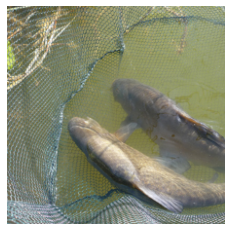

In [7]:
user.plot(true_user_data)

### Reconstruct user data:

In [8]:
reconstructed_user_data, stats = attacker.reconstruct(server_payload, shared_data, 
                                                      server.secrets, dryrun=cfg.dryrun)

# How good is the reconstruction?
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=False)

| It: 1 | Rec. loss: 1.1396 |  Task loss: 9.8151 | T: 0.09s
| It: 1001 | Rec. loss: 0.8264 |  Task loss: 9.5855 | T: 41.43s
| It: 2001 | Rec. loss: 0.8642 |  Task loss: 5.4438 | T: 41.18s
| It: 3001 | Rec. loss: 0.8645 |  Task loss: 6.8589 | T: 41.32s
| It: 4001 | Rec. loss: 0.9687 |  Task loss: 11.4599 | T: 41.26s
| It: 5001 | Rec. loss: 0.9220 |  Task loss: 12.1360 | T: 41.13s
| It: 6001 | Rec. loss: 0.9080 |  Task loss: 6.4591 | T: 40.97s
| It: 7001 | Rec. loss: 0.9787 |  Task loss: 16.7828 | T: 41.00s
| It: 8001 | Rec. loss: 0.6918 |  Task loss: 13.0837 | T: 40.65s
| It: 9001 | Rec. loss: 0.8923 |  Task loss: 18.1339 | T: 40.64s
| It: 10001 | Rec. loss: 1.0090 |  Task loss: 16.0547 | T: 41.01s
| It: 11001 | Rec. loss: 0.8786 |  Task loss: 19.1142 | T: 40.99s
| It: 12001 | Rec. loss: 0.7976 |  Task loss: 22.9212 | T: 40.80s
| It: 13001 | Rec. loss: 0.5398 |  Task loss: 2.4113 | T: 40.93s
| It: 14001 | Rec. loss: 0.6031 |  Task loss: 5.8477 | T: 41.00s
| It: 15001 | Rec. loss: 0.4527

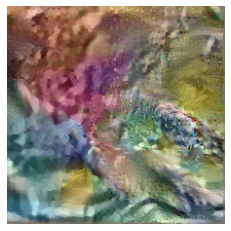

In [9]:
user.plot(reconstructed_user_data)

In [10]:
metrics = breaching.analysis.report(reconstructed_user_data, true_user_data, 
                                    server_payload, server.model, user.dataloader, setup=setup,
                                    order_batch=True, compute_full_iip=True)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /cmlscratch/jonas0/miniconda3/envs/dl/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth
METRICS: | MSE: 0.0373 | PSNR: 14.28 | FMSE: 1.8736e+00 | LPIPS: 0.74| R-PSNR:  nan | IIP-pixel: 100.00% | IIP-lpips: 0.00% | IIP-self: 100.00%
